# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

### Installing the DEAP framework

In [ ]:
!pip install deap

### Imports

In [1]:
from deap import gp, base, tools, creator, algorithms
import numpy as np
import matplotlib.pyplot as plt
import operator
import pandas as pd
import math
from sklearn.metrics import log_loss
import pdb
%matplotlib inline

## Constants

In [12]:
POP_SIZE = 10
N_GENERATIONS = 10
CROSSOVER_PROB = 0.7
MUTATION_PROB = 0.0 
CONTROL_BLOAT = False

### Define fitness function

In [13]:
mnist_df = pd.read_csv("../../../mnist.csv")

In [14]:
zeros_ones_df = mnist_df[mnist_df.label <= 1]

In [15]:
zeros_ones_labels = zeros_ones_df['label'].to_numpy()
zeros_ones_data = zeros_ones_df.drop('label', axis=1).to_numpy() / 255

In [16]:
def softmax(x):
    exp = np.exp(x -np.max(x))
    return exp / np.sum(exp)

In [17]:
def fitness(individual):
    # Transform tree expression into callable function
    # we have two outputs thus we should create two populations..
    func1 = toolbox.compile(expr = individual[0]) # predicts zeros?
    func2 = toolbox.compile(expr = individual[1]) # predicts ones?
    
    #simple case, lets start with evaluation on 10 random samples
    evaluation_indices = np.random.randint(len(zeros_ones_labels), size=(10,))
    
    # Compute sum of absolute errors
    # error = 0
    # for x, y in points.items():
    #     error += abs(func(x) - y)

    # we will try to compute the softmax cross entropy aka log loss
    y_trues = [zeros_ones_labels[x] for x in evaluation_indices]
    while (np.sum(y_trues) == 10 or np.sum(y_trues) == 0):
        evaluation_indices = np.random.randint(len(zeros_ones_labels), size=(10,))
        y_trues = [zeros_ones_labels[x] for x in evaluation_indices]
    
    y_preds = []
    for index in evaluation_indices:
        x = zeros_ones_data[index]
        y_pred_0 = func1(*x)
        y_pred_1 = func2(*x)
        y_pred_softmax = softmax([y_pred_0,y_pred_1])
        y_preds.append(y_pred_softmax)
    error = log_loss(y_trues,y_preds)
    return (error),

### Defining the set of operators and terminals

In [18]:
## determine number of inputs
nr_of_inputs = zeros_ones_data[0].shape[0]

In [19]:
# Create set of functions and terminals, with one terminal: x
pset = gp.PrimitiveSet("main", nr_of_inputs)
pset.renameArguments(ARG0="x")

In [20]:
# Define additional operators

### Basic mathematical functions with caveats ###

def div(a,b):
    # Ensure no division by 0 takes place
    return a/b if b else 0

def log(a):
    # Ensure no logarithm is taken of a non-positive value
    return math.log(a) if (a > 0) else 0

def exp(a):
    # Ensure no exponential is too big
    return math.exp(min(a,100))


### Activation functions ###

def relu(a):
    return a if a > 0.0 else 0.0

def sigmoid(a):
    return 1.0/(1.0 + math.exp(-a))

def tanh(a):
    return math.tanh(a)

In [21]:
# Add standard math operators to the set
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)

# Add math operators with caveats to the set
pset.addPrimitive(div, 2)
pset.addPrimitive(log, 1)
pset.addPrimitive(exp, 1)

# Add activation functions to the set
pset.addPrimitive(relu, 1)
pset.addPrimitive(sigmoid, 1)
pset.addPrimitive(tanh, 1)

### Define the creator that creates individuals (i.e. trees)

In [22]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Define the toolbox 
<b>(describes how to form a population, compile an expression as a function, evaluate fitness, select parents, perform cross-over and mutation)</b>

In [23]:
toolbox = base.Toolbox()
# Initial generation is generated using ramped half-and-half initialization, with a tree size between 1 and 5
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
# Define how to generate a population of individuals
## we want two outputs, we are prediciting 0 or 1 digit.
toolbox.register("individual1", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("individual2", tools.initIterate, creator.Individual, toolbox.expr)

toolbox.register("population1", tools.initRepeat, list, toolbox.individual1)
toolbox.register("population2", tools.initRepeat, list, toolbox.individual2)

# Define how to compile a tree as a function that can be evaluated
toolbox.register("compile", gp.compile, pset=pset)
# Define how to determine the fitness of an individual (using the fitness function defined above)
toolbox.register("evaluate", fitness)

# Define how to select parents (tournament selection; either controlling for bloat or not controlling for it)
if CONTROL_BLOAT:
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.3, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=3) # Do not control
# Define how to perform cross-over (pick one node of both parents & swap subtrees)
toolbox.register("mate", gp.cxOnePoint)
# Define how to perform mutation (not very important as mutation probability is set to 0)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Define upper limits for height of trees
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

### Define statistics that will be gathered

In [24]:
# Functions for determining average, min and max, which control for the possibility that the input might consist of tuples
def tuple_avg(a):
    if len(a[0]) == 2:
        return np.mean([x[0] for x in a])
    return np.mean(a)

def tuple_min(a):
    if len(a[0]) == 2:
        return np.min([x[0] for x in a])
    return np.min(a)

def tuple_max(a):
    if len(a[0]) == 2:
        return np.max([x[0] for x in a])
    return np.max(a)

# Function for determining the size of the agent with the best fitness
def tuple_best_size(a):
    if len(a[0]) == 2:
        return np.amax(a, 1)[0]
    return None

In [25]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(lambda ind: [len(ind), ind.fitness.values[0]])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg",  tuple_avg)
mstats.register("min",  tuple_min)
mstats.register("max",  tuple_max)
mstats.register("best", tuple_best_size)

### Run the genetic programming algorithm using the definitions above

In [26]:
pop1 = toolbox.population1(POP_SIZE)
pop2 = toolbox.population2(POP_SIZE)
hof1 = tools.HallOfFame(1)
hof2 = tools.HallOfFame(1)
# popa, loga = algorithms.eaSimple(population=pop1, 
#                                toolbox=toolbox, 
#                                cxpb=CROSSOVER_PROB, 
#                                mutpb=MUTATION_PROB, 
#                                ngen=N_GENERATIONS, 
#                                stats=mstats, 
#                                halloffame=hof, 
#                                verbose=True)

In [36]:

# inspired by https://github.com/DEAP/deap/issues/491
def Evolve(pop, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=__debug__):
    pop1 = pop[0]
    pop2 = pop[1]
   
    hof1 = halloffame[0]
    hof2 = halloffame[1]

    logbook1 = tools.Logbook()
    logbook2 = tools.Logbook()
    
    logbook1.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    logbook2.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    
    invalid_ind1 = [ind for ind in pop1 if not ind.fitness.valid]
    invalid_ind2 = [ind for ind in pop2 if not ind.fitness.valid]
  
    
    #Here, the function cost_function takes in 4 inputs. Thus, we need to zip the 4 individuals and pass it to the cost_function, that is represented here as "toolbox.evaluate". The returned list of cost is then evaluated for each of the individuals.
    fitnesses1 = toolbox.map(toolbox.evaluate, zip(invalid_ind1, invalid_ind2))
    for ind, fit in zip(invalid_ind1, fitnesses1):
        ind.fitness.values = fit
    fitnesses2 = toolbox.map(toolbox.evaluate, zip(invalid_ind1, invalid_ind2))
    for ind, fit in zip(invalid_ind2, fitnesses2):
        ind.fitness.values = fit

    hof1.update(pop1)
    hof2.update(pop2)

    
    record1 = stats.compile(pop1) if stats else {}
    record2 = stats.compile(pop2) if stats else {}

    logbook1.record(gen=0, nevals=len(invalid_ind1), **record1)
    logbook2.record(gen=0, nevals=len(invalid_ind2), **record2)

    if verbose:
        print(logbook1.stream, logbook2.stream)

    for gen in range(1, ngen + 1):
        offspring1 = toolbox.select(pop1, len(pop1))
        offspring2 = toolbox.select(pop2, len(pop2))

        
        offspring1 = algorithms.varAnd(offspring1, toolbox, cxpb, mutpb)
        offspring2 = algorithms.varAnd(offspring2, toolbox, cxpb, mutpb)
     
        
        invalid_ind1 = [ind for ind in offspring1 if not ind.fitness.valid]
        invalid_ind2 = [ind for ind in offspring2 if not ind.fitness.valid]
       
        
        fitness1 = toolbox.map(toolbox.evaluate, zip(invalid_ind1,invalid_ind2))
        for ind, fit in zip(invalid_ind1, fitness1):
            ind.fitness.values = fit

        fitness2 = toolbox.map(toolbox.evaluate, zip(invalid_ind1,invalid_ind2))
        for ind, fit in zip(invalid_ind2, fitness2):
            ind.fitness.values = fit
        
      
        
        hof1.update(offspring1)
        hof2.update(offspring2)
      
        
        pop1[:] = offspring1
        pop2[:] = offspring2
       
        record1 = stats.compile(pop1[0]) if stats else {}
        record2 = stats.compile(pop2[0]) if stats else {}
      
        logbook1.record(gen=gen, nevals=len(invalid_ind1), **record1)
        logbook2.record(gen=gen, nevals=len(invalid_ind2), **record2)
        
        if verbose:
            print(logbook1.stream, logbook2.stream)
            
    pop = [pop1, pop2]
    log = [logbook1, logbook2]
        
    return pop,log

In [40]:
pop1 = toolbox.population1(POP_SIZE)
pop2 = toolbox.population2(POP_SIZE)
hof1 = tools.HallOfFame(1)
hof2 = tools.HallOfFame(1)


pop,log = Evolve([pop1,pop2], toolbox, cxpb=CROSSOVER_PROB, 
                 mutpb=MUTATION_PROB, ngen=N_GENERATIONS, halloffame=[hof1,hof2], verbose=True)


gen	nevals
0  	10     gen	nevals
0  	10    
1  	8      1  	6     
2  	6      2  	8     
3  	4      3  	4     
4  	8      4  	10    
5  	8      5  	8     
6  	8      6  	6     
7  	8      7  	8     
8  	6      8  	8     
9  	2      9  	6     
10 	8      10 	6     


### Inspect best solution found

In [50]:
print(str(hof1[0])) #weird output..
print(str(hof2[0]))

cos(ARG780)
sub(relu(ARG293), exp(sigmoid(div(ARG407, exp(ARG436)))))


### Plotting

In [47]:
# Extract fitness of best individual in each generation
max_fitness = log[0].chapters["fitness"].select("max")

# Extract average, minimum and maximum size in each generation, as well as size corresponding to agent with best fitness
avg_size = log[0].chapters["size"].select("avg")
min_size = log[0].chapters["size"].select("min")
max_size = log[0].chapters["size"].select("max")
best_size = log[0].chapters["size"].select("best")

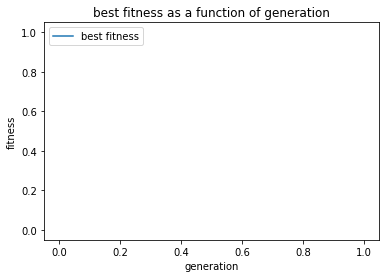

In [48]:
# Plot best fitness as a function of generation
plt.plot(max_fitness, label="best fitness")
plt.legend(loc="upper left")
plt.title("best fitness as a function of generation")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.show()

ValueError: operands could not be broadcast together with shapes (51,) (0,) 

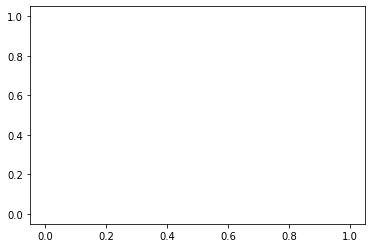

In [49]:
# Plot size as a function of generation
plt.plot(avg_size, label="average size")
plt.fill_between(np.arange(0,51,1), min_size, max_size, facecolor="blue", alpha=0.1, label="spread between min and max")
plt.plot(best_size, label="size of individual with best fitness")
plt.legend(loc="upper left")
plt.title("size as a function of generation")
plt.xlabel("generation")
plt.ylabel("size")
plt.show()